# Segmented Model for TN predictions

In [1]:
%load_ext watermark
%watermark -a "Bryan Dickinson" -d -t -v -p numpy,pandas

Bryan Dickinson 2020-09-28 16:26:37 

CPython 3.7.8
IPython 7.17.0

numpy 1.18.5
pandas 1.1.0


From correlation analysis, it would seem that different areas of the watershed have different distributions of Total Nitrogen. For example, if a point source that is polluting the bay in/near one of the tributaries, the concentration of TN would be higher near the source than further down stream where the pollution has a chance to be diluted.

From the previous analysis - there were indicators that there may be a different distributions of pollutants depending on location in the watershed. There are different methods of segmenting the data. Below will utilize the clustering algorithm DBSCAN to cluster HUC12 segment data on Distance from the outflow of the bay, TN, and TN variability.

 - These features may help identify HUC locations based on how pollutants flow into the bay and their past TN values


In [2]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='https://raw.githubusercontent.com/teamHackTheBay/hackTheBay/master/models/ensemble_model/visuals/distance_tn.png'></td><td><img src='https://raw.githubusercontent.com/teamHackTheBay/hackTheBay/master/models/ensemble_model/visuals/indicator.png'></td></tr></table>"))

,


The above photos show that while distance from the outflow of the bay is a correlated with total nitrogen, there are areas where levels of nitrogen is higher even when close to the bay such as the lower eastern shore. 


### Utilizing DBSCAN to segment the data

<!-- DBSCAN was used with an eps of 

all_data[all_data.new_date>='2016'][['of_dist','huc12_','tn']] -->

 Previous models received a RMSE of ~.80 and it was found that the models were heteroskedastic, the residuals for greater values of TN were much greater than the values of lower TN. This could be due to the skewed TN, greater observations of lower TN, the large range of values. (shown below). The model is doing a much better job predicting TN in HUC12 areas of lower values of TN than larger, more variable HUC12 locations. Segmenting the data using a clustering algorithm may help seperate out areas of higher TN.

The DBSCAN model can be found in the *'correlation_no2_data' notebook*.

**DBSCAN parameters:**<br/>
**eps** = .145<br/>
**min_samples** = 9<br/>
**features used:** *'distance from outflow of the bay'*, *TN variability*, *avg TN from within the HUC location*<br/>


The result of the tuned DBSCAN model can be seen below with mapped HUC12 locations on the map.

In [3]:
display(HTML("<table><tr><td><img src='https://raw.githubusercontent.com/teamHackTheBay/hackTheBay/master/models/ensemble_model/visuals/cluster_points.png'>"))
display(HTML("<table><tr><td><img src='https://raw.githubusercontent.com/teamHackTheBay/hackTheBay/master/models/ensemble_model/visuals/cluster_photo.png'></td><td><img src='https://raw.githubusercontent.com/teamHackTheBay/hackTheBay/master/models/ensemble_model/visuals/indicator.png'></td></tr></table>"))

,


The above cluster visualization looks similar to the earlier plot segmented by TN. It captures the 'poor' indicators locatd on the Lower Easter Shore, the fair to very poor HUC locations alot further north of the bay, and further east of the bay. It doesn't however capture the poor/very poor areas along the north part of the bay near Balitmore and Washington DC, nor does it capture the 'fair' from 'very good' along the Potomac and Rappahannock rivers.

Ideas to improve:
- Additional hyperparamter tuning of the model may help in segmenting the data
    - Robust vs Standard Scalers, and taking a log transformation of the total nitrogen may yield different results
- Simply creating models for varying level indicators vs using a clustering algorithm may yield similar/better results

The remaining portion of this notebook will look at creating two separate predictive models using the clusters that output from the result of the DBSCAN algrothim.

To scale this for the whole watershed would require comparing important features for both models and identifying any differences from these important features. Finally, attempting to utilize the identified features to then cluster the data again with the goal of creating similar clusters based on these important features and predict TN. If evaluation metrics are acceptable, this could scale to the whole watershed, with hydrologic units that do not have any TN samples in the data.


In [4]:
import os
import pandas as pd
import numpy as np
import eli5
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import shap

sns.set(context='notebook', style='dark', font_scale=1.5)

PROJ_ROOT = os.path.join(os.pardir)

C:\Users\Bryan\Anaconda3\envs\hacktb\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Bryan\Anaconda3\envs\hacktb\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
#import the cluster data

data_path = os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'cluster_data2.csv')
df=pd.read_csv(data_path, parse_dates=['new_date'])

# import the pollutant data by HUC
pollutants_path = (os.path.join(PROJ_ROOT, 
                         'data',
                        'raw-data',
                         'epa',
                         'pollutant_sums_by_hucyr.csv'))
huc_ps_df=pd.read_csv(pollutants_path)
huc_ps_df.drop(huc_ps_df.columns[0],inplace=True,axis=1)

In [6]:
huc_ps_df.head(1)

,total_no,year,huc,total_no_filled
0,0.0,2005,20700110206,383111177.5


In [7]:
df.shape

(66892, 63)

Trim the data by TN and by date.

The Chesapeake Bay Health indicator here: https://ian.umces.edu/ecocheck/report-cards/chesapeake-bay/2012/indicators/total_nitrogen/#_Data_Map segments the data with an upper limit of '>2'. With TN values in the data as high as 122, an arbitrary value of 50mg/L was chosen because it is considered to be dangerous and hazard.<br/><br/>
**<ins>More domain expertise is needed on evaluating what points can be errors/mistakes, and if the data above a certain level can be removed from the data.</ins><br/><br/>**

The date of 2015 was used due to the scarsity of the land cover data. The data is from 2016 (and is updated every 3 years from the USGS/MLRC). The assumption is made that not much change in land cover has happened from one year before the data, or 3 years after.<br/><br/>

https://www.who.int/water_sanitation_health/dwq/chemicals/nitratenitrite2ndadd.pdf<br/>
https://www.pca.state.mn.us/sites/default/files/wq-s6-26a2.pdf<br/>

In [8]:
# drop 22 records that are higher concentration than 50 mg/L
len(df[df.tn<50])
df=df[df.tn<50]
df=df[df.new_date >='2015']
df.shape

(23471, 63)

In [9]:
# TN distribution
df.tn.describe()

count    23471.000000
mean         1.731490
std          2.185355
min          0.020000
25%          0.620500
50%          1.090000
75%          2.033000
max         46.300000
Name: tn, dtype: float64

In [10]:

# functions used for mean target encoding TN by huc12 area

def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

def indicator(x):
    '''Function to create indicators of TN by observation'''
    if x <.56:
        return 'very good'
    elif x < .65:
        return 'good'
    elif x < 1:
        return 'fair'
    elif x < 1.5:
        return 'farily poor'
    elif x < 2:
        return 'poor'
    else:
        return 'very poor'
    
def combine_developed(x):
    '''function to merge the developed type land cover data'''
    cols=[c for c in x.index if c.startswith('lc_2')]
    ttl=x[cols].sum()
    return ttl


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23471 entries, 0 to 66891
Data columns (total 63 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   new_date         23471 non-null  datetime64[ns]
 1   latitude         23471 non-null  float64       
 2   longitude        23471 non-null  float64       
 3   sampledepth      23471 non-null  float64       
 4   huc12_           23471 non-null  int64         
 5   hucname_         23471 non-null  object        
 6   areaacres        23471 non-null  float64       
 7   za_mean          23471 non-null  float64       
 8   lc_0             23471 non-null  float64       
 9   lc_11            23471 non-null  float64       
 10  lc_21            23471 non-null  float64       
 11  lc_22            23471 non-null  float64       
 12  lc_23            23471 non-null  float64       
 13  lc_24            23471 non-null  float64       
 14  lc_31            23471 non-null  float

In [12]:
# subset the relevant data that will be used
df=df[['new_date','huc12_',
       'areaacres', 'za_mean', 'lc_21', 'lc_22',
       'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71',
       'lc_81', 'lc_82', 'lc_90', 'lc_95', 'month', 'year', 'week','day',
       'hour', 'min', 'tn', 'airtemp_narr',
       'precip3_narr', 'humidity_narr', 'cl_cover_narr', 'sfc_runoff',
       'sfc_air_narr', 'u_wind_narr', 'v_wind_narr', 'windspeed_narr',
       'wdirection_narr', 'precip24_narr', 'precip48_narr', 'quan_10',
       'n_bins', 'n', 'of_dist', 'date','distance10',
       'arithmetic_mean', 'first_max_value',
       'correlated', 'indicator', 'mean_tn', 'cluster']]

In [13]:
# Factorize the categorical data points
df['correlated'] = df.correlated.factorize()[0]
df['indicator'] = df.indicator.factorize()[0]

Aggregate the data. Currently observations are by min. With many observations in an hour or day. Aggregating the data can help limit the variations seen in the data. 

More domain expertise is needed here. For determing import features, by month seems like a good level to view the data. To improve this model, determining confidence intervals here could prove useful.

In [14]:
# group the data, observations down to the hour or day can create a lot of

# aggreagate by day
# grouped_df = df.groupby(['huc12_','year','month','day'], as_index=False).mean()

#aggregate by month
grouped_df = df.groupby(['huc12_','year','month'], as_index=False).mean()

In [15]:
# check how for the most number of samples taken at one site in a day
# df.groupby(['huc12_','year','month','day'], as_index=False)['tn'].count().sort_values(by='tn',ascending=False).head(1)

# check how for the most number of samples taken at one site in a month
df.groupby(['huc12_','year','month'], as_index=False)['tn'].count().sort_values(by='tn',ascending=False).head(1)

,huc12_,year,month,tn
2316,20600010000,2016,8,43


In [16]:
#look at the distribution of number of samples in one day
# print(df.groupby(['huc12_','year','month','day'], as_index=False)['tn'].count().tn.value_counts().sort_index())
# print(df.groupby(['huc12_','year','month','day'], as_index=False)['tn'].count().tn.value_counts(normalize=True).sort_index())

#look at the distribution of number of samples in one month
print(df.groupby(['huc12_','year','month'], as_index=False)['tn'].count().tn.value_counts().sort_index())
print(df.groupby(['huc12_','year','month'], as_index=False)['tn'].count().tn.value_counts(normalize=True).sort_index())

1     8154
2     2936
3     1124
4      417
5      109
6       81
7       28
8       13
9       26
10      12
11       5
12       3
13      27
14       3
15       3
16       5
18       8
19       9
20      20
21       6
22       7
23       2
24       9
29       1
30       1
35       2
36       1
37       1
38       1
39       3
40       3
41       4
42       2
43       3
Name: tn, dtype: int64
1     0.625835
2     0.225343
3     0.086269
4     0.032006
5     0.008366
6     0.006217
7     0.002149
8     0.000998
9     0.001996
10    0.000921
11    0.000384
12    0.000230
13    0.002072
14    0.000230
15    0.000230
16    0.000384
18    0.000614
19    0.000691
20    0.001535
21    0.000461
22    0.000537
23    0.000154
24    0.000691
29    0.000077
30    0.000077
35    0.000154
36    0.000077
37    0.000077
38    0.000077
39    0.000230
40    0.000230
41    0.000307
42    0.000154
43    0.000230
Name: tn, dtype: float64


In [17]:
# group the data by day
# grouped_df=df.groupby(['huc12_','year','month','day'], as_index=False).mean()

#group the data by month
grouped_df=df.groupby(['huc12_','year','month'], as_index=False).mean()

In [18]:
grouped_df.shape

(13029, 45)

In [19]:
grouped_df.columns

Index(['huc12_', 'year', 'month', 'areaacres', 'za_mean', 'lc_21', 'lc_22',
       'lc_23', 'lc_24', 'lc_31', 'lc_41', 'lc_42', 'lc_43', 'lc_52', 'lc_71',
       'lc_81', 'lc_82', 'lc_90', 'lc_95', 'week', 'day', 'hour', 'min', 'tn',
       'airtemp_narr', 'precip3_narr', 'humidity_narr', 'cl_cover_narr',
       'sfc_runoff', 'sfc_air_narr', 'u_wind_narr', 'v_wind_narr',
       'windspeed_narr', 'wdirection_narr', 'precip24_narr', 'precip48_narr',
       'n', 'of_dist', 'distance10', 'arithmetic_mean', 'first_max_value',
       'correlated', 'indicator', 'mean_tn', 'cluster'],
      dtype='object')

Grouping the data by day or month may have affected the weather data, however the land cover data would have been the same.

Take a look at the distribution of the segments provided by the DBSCAN algorithm.
- 3.0 and 0.0 are in one group and considered 'good/fair' TN values that are close to the bay
- -1.0, 1.0 and 2.0 are in the othe rgroup and considered 'poor' TN values and are further from the bay


In [20]:
print(df.cluster.value_counts())
print(df.cluster.value_counts(normalize=True))

-1.0    12611
 0.0     6886
 3.0     2110
 1.0     1118
 2.0      746
Name: cluster, dtype: int64
-1.0    0.537301
 0.0    0.293383
 3.0    0.089898
 1.0    0.047633
 2.0    0.031784
Name: cluster, dtype: float64


In [21]:
print(grouped_df.cluster.value_counts(normalize=True))
print(df.cluster.value_counts())

-1.0    0.547625
 0.0    0.296953
 1.0    0.058562
 3.0    0.052191
 2.0    0.044670
Name: cluster, dtype: float64
-1.0    12611
 0.0     6886
 3.0     2110
 1.0     1118
 2.0      746
Name: cluster, dtype: int64


NO2 seems to have a slight seasonal affect. 
More data is needed ( or more domain knowledge) by month to accuratley breakdown this yearly data by month/day. Determing the type of point source solution may also help. <br/>
Data from Seasonal Characteristics of NOX is utilized. To weight each month's total to the yearly NO2 emission for each point source.

https://www.sciencedirect.com/science/article/pii/S1309104215304475



In [22]:
# monthly average concentrations of air NO2 readings
navgs = np.array([16.9,15.9,16.3,20.2,17.7,15.5,14.3,14.6,15.5,16.4,12.9,16.7])

# dividing by the yearly average
nwts = navgs/16.1

In [23]:
# weights to be used to convert the yearly emissions data to monthly averages
nwts

array([1.04968944, 0.98757764, 1.01242236, 1.25465839, 1.09937888,
       0.96273292, 0.88819876, 0.9068323 , 0.96273292, 1.01863354,
       0.80124224, 1.03726708])

In [24]:

# merge the grouped data to the pollution data
grouped_df=pd.merge(grouped_df,
                    huc_ps_df[['year','huc','total_no_filled']],
                    left_on=['huc12_','year'],
                    right_on=['huc','year'],
                    how='left' )


In [25]:
# missing values
grouped_df.total_no_filled.isna().sum()

757

There is missing values for air emissions data. The missing values will be filled with the global mean

In [26]:
#fill in missing HUC code information with the global mean
grouped_df.total_no_filled.fillna(grouped_df.total_no_filled.mean(),inplace=True)

In [27]:
#drop the redudant huc column
grouped_df.drop(['huc'],axis=1,inplace=True)

In [28]:
# create a function to calculate monthly totals based on the yearly point
# source emission and the calculated monthly weights

def adjusted_monthly_no2(x):
    #divide to calculate the montly total
    monthly_total = x.total_no_filled/12
    #adjust for seasonality
    adj_monthly_ttl = monthly_total*nwts[int(x.month)-1]
    
    return adj_monthly_ttl

grouped_df['no2_emission']=grouped_df.apply(adjusted_monthly_no2,axis=1)

In [29]:
# combine the land cover 'develeoped' data together
grouped_df['lc_20'] = grouped_df.apply(combine_developed, axis=1)

cols = [c for c in grouped_df.columns if c.startswith('lc_2') and c is not 'lc_20']
grouped_df.drop(cols, axis=1, inplace=True)


In [30]:
grouped_df.columns

Index(['huc12_', 'year', 'month', 'areaacres', 'za_mean', 'lc_31', 'lc_41',
       'lc_42', 'lc_43', 'lc_52', 'lc_71', 'lc_81', 'lc_82', 'lc_90', 'lc_95',
       'week', 'day', 'hour', 'min', 'tn', 'airtemp_narr', 'precip3_narr',
       'humidity_narr', 'cl_cover_narr', 'sfc_runoff', 'sfc_air_narr',
       'u_wind_narr', 'v_wind_narr', 'windspeed_narr', 'wdirection_narr',
       'precip24_narr', 'precip48_narr', 'n', 'of_dist', 'distance10',
       'arithmetic_mean', 'first_max_value', 'correlated', 'indicator',
       'mean_tn', 'cluster', 'total_no_filled', 'no2_emission', 'lc_20'],
      dtype='object')

In [31]:
grouped_df.to_csv(os.path.join(PROJ_ROOT, 
                         'data',
                        'processed',
                         'final_ens_data.csv'),index=False)

Drop the unused columns from aggregating to month, and merging with other data

In [32]:
# dropped_cols=['mean_tn','n','week','hour','min','total_no_filled']
dropped_cols=['mean_tn','n','week','hour','min','day','total_no_filled']

### Determining additional columns to drop due to collinearity

In [33]:
corr = grouped_df.drop(dropped_cols,axis=1).corr()
corr = corr.abs().unstack()
corr = corr.sort_values(ascending = False)
corr=pd.DataFrame(corr).reset_index()#.columns=['ft1','ft2','corr']
corr.columns=['ft1','ft2','corr']
corr[(corr['corr']>.8) & (corr['corr'] <1)]

,ft1,ft2,corr
37,wdirection_narr,u_wind_narr,1.000000
38,u_wind_narr,wdirection_narr,1.000000
39,airtemp_narr,sfc_air_narr,0.972993
40,sfc_air_narr,airtemp_narr,0.972993
41,v_wind_narr,wdirection_narr,0.924918
42,wdirection_narr,v_wind_narr,0.924918
43,v_wind_narr,u_wind_narr,0.924918
44,u_wind_narr,v_wind_narr,0.924918
45,first_max_value,arithmetic_mean,0.898943
46,arithmetic_mean,first_max_value,0.898943


Drop the below columns that had a high correlation with other features. The features that were selected held a slightly higher correlation with the TN feature.

In [34]:
dropped_cols = dropped_cols + ['u_wind_narr','sfc_air_narr','v_wind_narr','first_max_value','precip48_narr']

In [35]:
#check taht there are no more  feautres that are correlated

corr = grouped_df.drop(dropped_cols,axis=1).corr()
corr = corr.abs().unstack()
corr = corr.sort_values(ascending = False)
corr=pd.DataFrame(corr).reset_index()
corr.columns=['ft1','ft2','corr']
corr[(corr['corr']>.8) & (corr['corr'] <1)]

,ft1,ft2,corr


### Segment the data and correlate the data with TN

Other combinations can be tried, such as creating more than two models, and segmenting the data by each group from the clustering algorithm, or, by each TN indicator.

In [36]:
# df1=grouped_df[grouped_df.cluster==1.0]
# df2=grouped_df[grouped_df.cluster!=1.0]

df1=grouped_df[grouped_df.cluster.isin([3.0,0.0])]
df2=grouped_df[grouped_df.cluster.isin([2.0,-1.0,1.0 ])]

#### All the data together

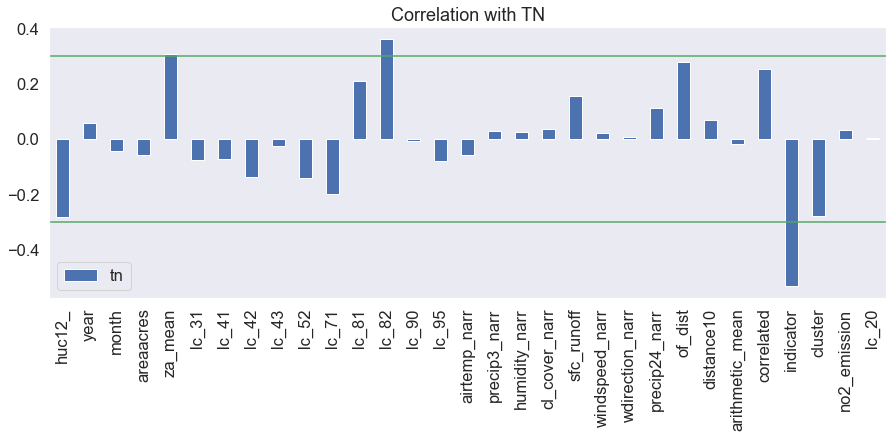

In [37]:
corr = grouped_df.drop(dropped_cols,axis=1).corr()
corr=corr[['tn']].drop('tn')
corr.plot(kind='bar', figsize=(15,5))
plt.axhline(y=0.3, color='g', linestyle='-')
plt.axhline(y=-0.3, color='g', linestyle='-')
_=plt.title('Correlation with TN')
plt.show()

#### Only the 'close/low TN' data from the first group

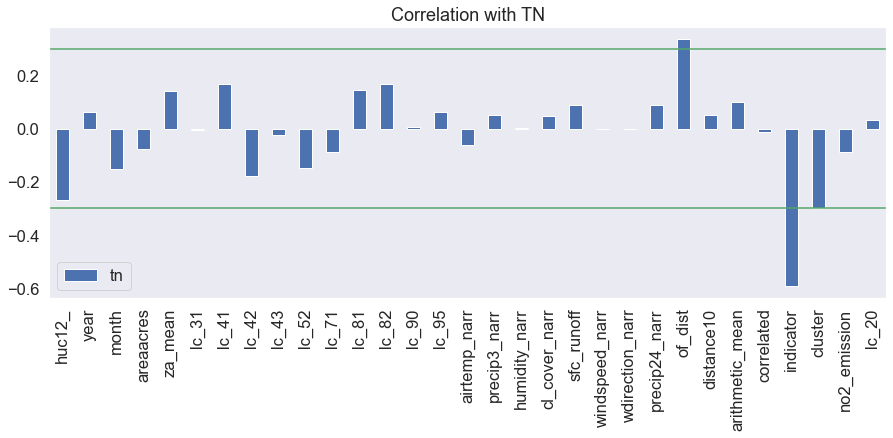

In [38]:
corr = df1.drop(dropped_cols,axis=1).corr()
corr=corr[['tn']].drop('tn')
corr.plot(kind='bar', figsize=(15,5))
plt.axhline(y=0.3, color='g', linestyle='-')
plt.axhline(y=-0.3, color='g', linestyle='-')
_=plt.title('Correlation with TN')
plt.show()

#### Only the 'far'/'high TN' data from the second group

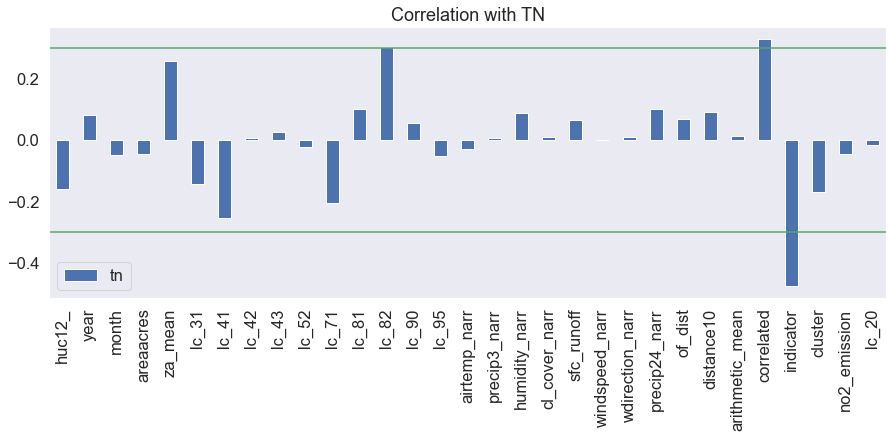

In [39]:
corr = df2.drop(dropped_cols,axis=1).corr()
corr=corr[['tn']].drop('tn')
corr.plot(kind='bar', figsize=(15,5))
plt.axhline(y=0.3, color='g', linestyle='-')
plt.axhline(y=-0.3, color='g', linestyle='-')
_=plt.title('Correlation with TN')
plt.show()

While there are no highly correlated features, there are some interesting observations between the plots.

- Most notably, land cover 81 & 82 seem to have a higher correlation with the second group than with the first. 
- Distance from the outflow of the bay seems to have a hgiher correlation with the first group, and minimal correlation with the second group.
- The 'correlated' feature seems to have a correlation with the second group, and there seems to be no correlation with the first group.

In [40]:
# remove additional duplicate features that have minimal/no correlation with TN
dropped_cols = dropped_cols + ['wdirection_narr','precip3_narr','cl_cover_narr','indicator']

In [41]:
grouped_df.drop(['tn'],axis=1).shape

(13029, 43)

In [42]:

# create bins for the TN feature
bins = pd.IntervalIndex.from_tuples([(0, .56), (.56,.65), (.65, 1),(1,1.5), (1.5,2), (2,np.inf)], closed='left')
grouped_df['n_bins']=pd.cut(grouped_df.tn, bins=bins, labels=False)
df1=grouped_df[grouped_df.cluster.isin([3.0,0.0])]

# split the data and stratify on the n_bins column to ensure there is a 
# similar distribution of TN in both the test and train datasets
X_train, X_test, y_train, y_test = train_test_split(df1.drop(dropped_cols+['tn'],axis=1),
                                                    df1['tn'],
                                                    test_size=.2,
                                                    random_state=5,
                                                    stratify=df1['n_bins'])

In [43]:
# ensure that the target variable is stratified across the different values of TN to generalize better
display(df1.n_bins.value_counts(normalize=True))
display(X_train.n_bins.value_counts(normalize=True))

# drop n_bins column
X_train.drop(['n_bins'],inplace=True,axis=1)
X_test.drop(['n_bins'],inplace=True,axis=1)

[0.65, 1.0)     0.374148
[0.0, 0.56)     0.339195
[0.56, 0.65)    0.140251
[1.0, 1.5)      0.129919
[1.5, 2.0)      0.014509
[2.0, inf)      0.001978
Name: n_bins, dtype: float64

[0.65, 1.0)     0.374279
[0.0, 0.56)     0.339104
[0.56, 0.65)    0.140148
[1.0, 1.5)      0.129981
[1.5, 2.0)      0.014564
[2.0, inf)      0.001924
Name: n_bins, dtype: float64

In [44]:
# create a mean target encoding for each huc12 segment and place in both training and test sets
X_train['tn']=y_train
X_train['huc12_enc'], X_test['huc12_enc'] = mean_target_encoding(train=X_train,
                                                                           test=X_test,
                                                                           target='tn',
                                                                           categorical='huc12_',
                                                                           alpha=10)
X_train.drop(['tn'],inplace=True, axis=1)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [45]:
# drop  the HUC12 feature
X_train.drop(['huc12_'], axis=1, inplace=True)
X_test.drop(['huc12_'], axis=1, inplace=True)

In [46]:
X_train.shape

(3639, 27)

In [47]:
X_test.shape

(910, 27)

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import OneHotEncoder

In [49]:
###### params for one hot encoding

# ohe_features = ['year','month']
# ohe_transformer = Pipeline(steps=[
#     ('ohe', OneHotEncoder(handle_unknown='ignore'))])

# numeric_features = list(set(X_train.columns).difference(set(['year','month'])))
# scaling = Pipeline(steps=[
#     ('rb_scaler', RobustScaler())])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('one_hot', ohe_transformer, ohe_features),
#         ('scaler', scaling, numeric_features)], remainder='passthrough')

# pipe=Pipeline([
#     ('preprocessing', preprocessor),
#     ('clf', RandomForestRegressor())
# ])

# create a pipeline to scale the non-categorical features
numeric_features = list(set(X_train.columns).difference(set(['year','month'])))
scaling = Pipeline(steps=[
    ('rb_scaler', RobustScaler())])

# create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaling, numeric_features)],remainder='passthrough')

#create the ML pipeline
pipe=Pipeline([
    ('preprocessing', preprocessor),
    ('clf', RandomForestRegressor())
])

# hyperparameter tuning
params = [{'clf' : [ RandomForestRegressor(random_state = 5, oob_score=True)],
    'clf__max_depth':[None],
    'clf__n_estimators' : [140],
    'clf__max_features' : ['auto']
          }
]



## Create Group 1 Model

In [50]:
#create the grid search object
# neg mean absolute error was chosen due to it's robustness against outliers
cv = GridSearchCV(pipe,
                  param_grid=params,
                  refit = True,
                  cv = 5, 
                  verbose = True,
                  n_jobs = -1, 
                 scoring='neg_mean_absolute_error') 

#fit the data
cv.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('rb_scaler',
                                                                                          RobustScaler())]),
                                                                         ['distance10',
                                                                          'lc_41',
                                                                          'correlated',
                                                                          'areaacres',
                                                                          'lc_95',
                                                                          'sfc_runoff',
                             

In [51]:
# for one hot encoding features

# oh_columns = pipe.named_steps['preprocessing'].transformers[0][1].named_steps['ohe'].fit(X_train[ohe_features]).get_feature_names()
# numeric_features_list = list(numeric_features)
# numeric_features_list.extend(oh_columns)

In [52]:
# print the parameters and the best score
print(cv.best_params_)
print(cv.best_score_)

{'clf': RandomForestRegressor(n_estimators=140, oob_score=True, random_state=5), 'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__n_estimators': 140}
-0.13964972923930824


### Group 1 Evaluation Metrics

In [53]:
# eval metrics
y_pred = cv.predict(X_test)
print(mean_squared_error(y_test,y_pred))

print(r2_score(y_test,y_pred))
print(1-(1-r2_score(y_test,y_pred))*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1)) #adjusted r2

0.04033419693126853
0.5804970309283913
0.5676551033037502


In [54]:
#
confidence = .95
final_mse = mean_squared_error(y_test, y_pred)
final_rmse = np.sqrt(final_mse)

squared_errors = (y_pred - y_test)**2
print('ev:',explained_variance_score(y_test, y_pred))
print('mse:',final_mse)
print('rmse:',final_rmse)
print('r2:',r2_score(y_test,y_pred))
print('Confidence Interval:',np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors))),'mg/L')

ev: 0.5805016702148609
mse: 0.04033419693126853
rmse: 0.20083375446191443
r2: 0.5804970309283913
Confidence Interval: [0.17007978 0.22746706] mg/L


### Group 1 Feature Importance

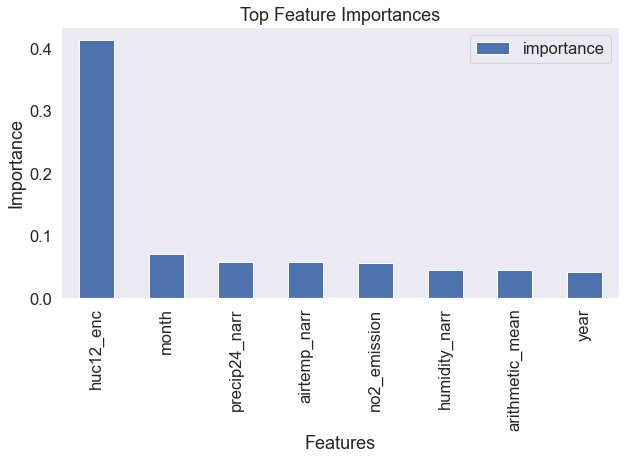

In [55]:
#obtain the feature importances from within the GridSearchCV, pipeline
fi=[x.feature_importances_ for x in cv.best_estimator_.steps[1][1].estimators_]
fi=np.mean(fi,axis=0)

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(fi,
                                   index = numeric_features+['year','month'], #numeric_features_list for one hot encoding
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances[:8].plot(kind='bar', figsize=(10,5))
_=plt.title('Top Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [56]:
eli5.explain_weights(cv.best_estimator_.steps[1][1], top=10, feature_names=numeric_features+['year','month'])

Weight,Feature
0.4140 ± 0.0289,huc12_enc
0.0716 ± 0.0162,month
0.0579 ± 0.0193,precip24_narr
0.0576 ± 0.0231,airtemp_narr
0.0560 ± 0.0200,no2_emission
0.0462 ± 0.0174,humidity_narr
0.0457 ± 0.0186,arithmetic_mean
0.0424 ± 0.0174,year
0.0419 ± 0.0160,windspeed_narr
0.0199 ± 0.0128,distance10


In [57]:
# load predictions to a dataframe
preds1=pd.DataFrame({'prediction':y_pred,'actual':y_test})

#### Normalized residual vs predicted values

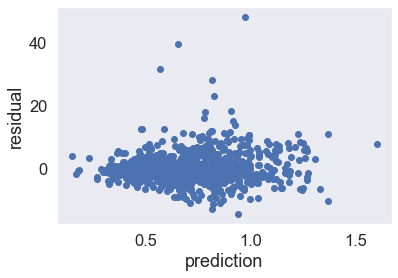

In [58]:
resid = y_test - y_pred
mean_resid = resid.mean()
std_resid = resid.std()

# calculate z statistic, define outliers to be where |z|>sigma
z = (resid - mean_resid)/std_resid    
outliers = z[abs(z)>3].index

plt.scatter(y_pred,(y_test-y_pred)/mean_squared_error(y_test, y_pred))
plt.xlabel('prediction')
plt.ylabel('residual')
plt.show()

There appears to be some heteroskedasticity

### Find and visualize outliers

In [59]:

#from lightgbm import LGBMRegressor
def find_outliers(y_pred, y, sigma=3):
   # predict y values using model
#    y_pred = pd.Series(model.predict(X), index=y.index)
   
   # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()

   # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid)/std_resid    
    z.reset_index(inplace=True, drop=True)
    outliers = z[abs(z)>sigma].index
    
   
   # print and plot the results
    print('R2:',r2_score(y,y_pred))
    print('mse:',mean_squared_error(y, y_pred))
    print('ev:',explained_variance_score(y, y_pred))
    print('rmse:',np.sqrt(mean_squared_error(y, y_pred)))
    print('---------------------------------------')

    print('mean of residuals:',mean_resid)
    print('std of residuals:',std_resid)
    print('---------------------------------------')

    print(len(outliers),'outliers:')
    print(outliers.tolist())
    

    plt.figure(figsize=(20,8))
    ax_231 = plt.subplot(2,3,1)
    plt.plot(y,y_pred,'.')
    plt.plot(y.iloc[outliers.tolist()].values,pd.DataFrame(y_pred).iloc[outliers.tolist()].values, 'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred');

    ax_232=plt.subplot(2,3,2)
    plt.plot(y,y-y_pred,'.')
    plt.plot(pd.DataFrame(y).iloc[outliers],pd.DataFrame(y-y_pred).iloc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred');

    ax_233=plt.subplot(2,3,3)
    z.plot.hist(bins=50,ax=ax_233)
    z.iloc[outliers].plot.hist(color='r',bins=50,ax=ax_233)
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('z');
   
    ax_234=plt.subplot(2,3,4)
    plt.plot(y,z,'.')
    plt.plot(pd.DataFrame(y).iloc[outliers],pd.DataFrame(z).iloc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y')
    plt.ylabel('standardized residuals');
    
    
    
    ax_235=plt.subplot(2,3,5)
    plt.plot(y_pred,z,'.')
    plt.plot(pd.DataFrame(y_pred,columns=['tn']).iloc[outliers],pd.DataFrame(z).iloc[outliers],'ro')
    plt.legend(['Accepted','Outlier'])
    plt.xlabel('y_pred')
    plt.ylabel('standardized residuals')

#     plt.savefig('outliers.png')
   
    return outliers

#find_outliers(model, X, y, sigma=3)

R2: 0.9419434991690854
mse: 0.005187168876637491
ev: 0.941976883458031
rmse: 0.0720220027258163
---------------------------------------
mean of residuals: -0.0017270735406971717
std of residuals: 0.0720111873499097
---------------------------------------
60 outliers:
[3, 15, 168, 267, 284, 353, 443, 578, 609, 727, 805, 853, 889, 974, 987, 1074, 1118, 1160, 1206, 1219, 1224, 1244, 1357, 1361, 1382, 1411, 1413, 1450, 1467, 1468, 1474, 1475, 1554, 1566, 1781, 1908, 2005, 2027, 2281, 2317, 2328, 2342, 2379, 2409, 2459, 2552, 2592, 2616, 2871, 2981, 3015, 3016, 3167, 3170, 3179, 3238, 3326, 3609, 3611, 3630]


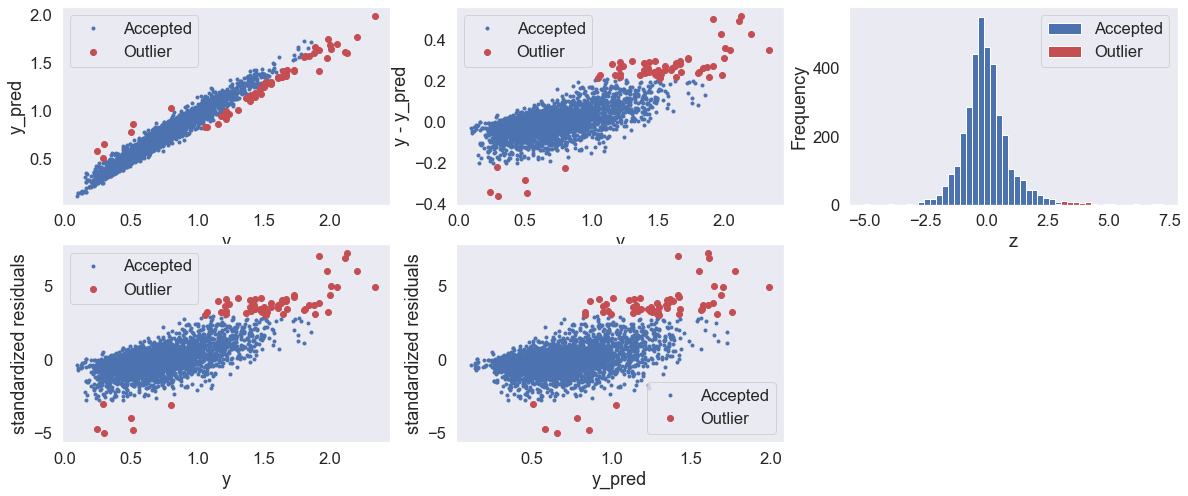

In [60]:
outliers = find_outliers(cv.predict(X_train), y_train, 3)

## Create Group 2 Model

In [61]:
bins = pd.IntervalIndex.from_tuples([(0, .56), (.56,.65), (.65, 1),(1,1.5), (1.5,2), (2,np.inf)], closed='left')
grouped_df['n_bins']=pd.cut(grouped_df.tn, bins=bins, labels=False)

df2=grouped_df[grouped_df.cluster.isin([2.0,-1.0,1.0 ])]


X_train, X_test, y_train, y_test = train_test_split(df2.drop(dropped_cols+['tn'],axis=1),
                                                    df2['tn'],
                                                    test_size=.2,
                                                    random_state=5,
                                                    stratify=df2['n_bins'])

display(df2.n_bins.value_counts(normalize=True))
display(X_train.n_bins.value_counts(normalize=True))

# drop n_bins column
X_train.drop(['n_bins'],inplace=True,axis=1)
X_test.drop(['n_bins'],inplace=True,axis=1)

X_train['tn']=y_train
X_train['huc12_enc'], X_test['huc12_enc'] = mean_target_encoding(train=X_train,
                                                                           test=X_test,
                                                                           target='tn',
                                                                           categorical='huc12_',
                                                                           alpha=10)
X_train.drop(['tn'],inplace=True, axis=1)

X_train.drop(['huc12_'], axis=1, inplace=True)
X_test.drop(['huc12_'], axis=1, inplace=True)

[2.0, inf)      0.389387
[1.0, 1.5)      0.187736
[1.5, 2.0)      0.165802
[0.65, 1.0)     0.133137
[0.0, 0.56)     0.094811
[0.56, 0.65)    0.029127
Name: n_bins, dtype: float64

[2.0, inf)      0.389298
[1.0, 1.5)      0.187795
[1.5, 2.0)      0.165831
[0.65, 1.0)     0.133107
[0.0, 0.56)     0.094782
[0.56, 0.65)    0.029186
Name: n_bins, dtype: float64

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [62]:
#create the grid search object
cv2 = GridSearchCV(pipe,
                  param_grid=params,
                  refit = True,
                  cv = 5, 
                  verbose = True,
                  n_jobs = -1
                  ,
                 scoring='neg_mean_absolute_error')

#fit the data
cv2.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         Pipeline(steps=[('rb_scaler',
                                                                                          RobustScaler())]),
                                                                         ['distance10',
                                                                          'lc_41',
                                                                          'correlated',
                                                                          'areaacres',
                                                                          'lc_95',
                                                                          'sfc_runoff',
                             

In [63]:
print(cv2.best_params_)
print(cv2.best_score_)
y_pred2 = cv2.predict(X_test)
print(mean_squared_error(y_test,y_pred2))

print(r2_score(y_test,y_pred2))
print(1-(1-r2_score(y_test,y_pred2))*(len(X_test)-1)/(len(X_test)-X_test.shape[1]-1)) #adjusted r2

{'clf': RandomForestRegressor(n_estimators=140, oob_score=True, random_state=5), 'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__n_estimators': 140}
-0.4114548751415422
0.5361225436681062
0.9042251092558393
0.9026747962761676


In [64]:

confidence = .95
final_mse = mean_squared_error(y_test, y_pred2)
final_rmse = np.sqrt(final_mse)

squared_errors = (y_pred2 - y_test)**2
print('ev:',explained_variance_score(y_test, y_pred2))
print('mse:',final_mse)
print('rmse:',final_rmse)
print('r2:',r2_score(y_test,y_pred2))
print('confidence interval:',np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors))),'mg/L')

ev: 0.9043656282572353
mse: 0.5361225436681062
rmse: 0.7322038948736248
r2: 0.9042251092558393
confidence interval: [0.47300489 0.92114682] mg/L


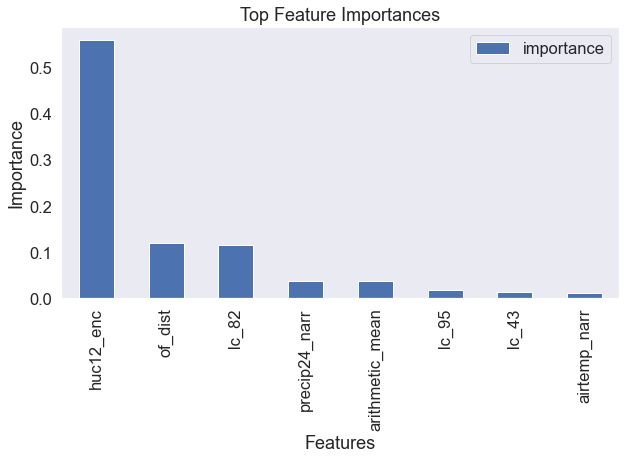

In [65]:
#obtain the feature importances from within the GridSearchCV, pipeline
fi=[x.feature_importances_ for x in cv2.best_estimator_.steps[1][1].estimators_]
fi=np.mean(fi,axis=0)

#place the feature importances in a dataframe
feature_importances = pd.DataFrame(fi,
                                   index =numeric_features+['year','month'], #use numeric_features_list for ohe
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances[:8].plot(kind='bar', figsize=(10,5))
_=plt.title('Top Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [66]:
preds2=pd.DataFrame({'prediction':y_pred2,'actual':y_test})

24


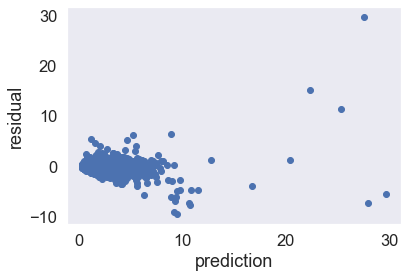

In [67]:
resid = y_test - y_pred2
mean_resid = resid.mean()
std_resid = resid.std()

# calculate z statistic, define outliers to be where |z|>sigma
z = (resid - mean_resid)/std_resid    
outliers = z[abs(z)>3].index
print(len(outliers))
plt.scatter(y_pred2,(y_test-y_pred2)/mean_squared_error(y_test, y_pred2))
plt.xlabel('prediction')
plt.ylabel('residual')
plt.show()

### Combine the model predictions

In [68]:
c_preds = pd.concat([preds1,preds2])

In [69]:
numeric_features.remove('cluster')

In [70]:
print('mse: ',mean_squared_error(c_preds.actual.values,c_preds.prediction.values))
print('rmse: ',np.sqrt(mean_squared_error(c_preds.actual.values,c_preds.prediction.values)))
print('ev:',explained_variance_score(c_preds.actual.values, c_preds.prediction.values))
print('r2:',r2_score(c_preds.actual.values,c_preds.prediction.values))

mse:  0.3629961447692105
rmse:  0.6024916138579943
ev: 0.9137515573651842
r2: 0.9136743393631287


The RMSE of .6 is a better performance than the previous models

In [71]:
from collections import defaultdict
def create_models(df = grouped_df, dropped_cols=dropped_cols, params=params):
    
    models=defaultdict(list)
    
    df1=grouped_df[grouped_df.cluster.isin([3.0,0.0])]
    df2=grouped_df[grouped_df.cluster.isin([2.0,-1.0,1.0 ])]
    
 
    
    for df in [df1, df2]:
        
        try:
            bins = pd.IntervalIndex.from_tuples([(0, .56), (.56,.65), (.65, 1),(1,1.5), (1.5,2), (2,np.inf)], closed='left')
            df['n_bins']=pd.cut(df.tn, bins=bins, labels=False)
            
            X_train, X_test, y_train, y_test = train_test_split(df.drop(dropped_cols+['tn'],axis=1),
                                                            df['tn'],
                                                            test_size=.2,
                                                            random_state=5,
                                                            stratify=df['n_bins'])

        except:
            
            bins = pd.IntervalIndex.from_tuples([(0, .56), (.56,.65), (.65, 1),(1,np.inf)], closed='left')
            df['n_bins']=pd.cut(df.tn, bins=bins, labels=False)
            
            X_train, X_test, y_train, y_test = train_test_split(df.drop(dropped_cols+['tn'],axis=1),
                                                            df['tn'],
                                                            test_size=.2,
                                                            random_state=5,
                                                            stratify=df['n_bins'])

        # drop n_bins column and the cluster column utilized for segmenting the data
        X_train.drop(['n_bins','cluster'],inplace=True,axis=1)
        X_test.drop(['n_bins','cluster'],inplace=True,axis=1)


        # mean target encoding
        X_train['tn']=y_train
        X_train['huc12_enc'], X_test['huc12_enc'] = mean_target_encoding(train=X_train,
                                                                                   test=X_test,
                                                                                   target='tn',
                                                                                   categorical='huc12_',
                                                                                   alpha=10)

        
        X_train.drop(['huc12_','tn'], axis=1, inplace=True)
        X_test.drop(['huc12_'], axis=1, inplace=True)



        numeric_features = list(set(X_train.columns).difference(set(['year','month'])))
        scaling = Pipeline(steps=[
            ('rb_scaler', RobustScaler())])

        preprocessor = ColumnTransformer(
            transformers=[
                ('scaler', scaling, numeric_features)],remainder='passthrough')

        pipe=Pipeline([
            ('preprocessing', preprocessor),
            ('clf', RandomForestRegressor())
        ])

#         params = [{'clf' : [ RandomForestRegressor(random_state = 5, criterion='mse',oob_score=True)],
#         'clf__max_depth':[None, 2, 5, 8 ],
#         'clf__n_estimators' : [140] + list(range(20,300, 40)),
#         'clf__max_features' : ['log2', 'sqrt','auto']
#               }
#     ]

        #create the grid search object
        cv = GridSearchCV(pipe,
                          param_grid=params,
                          refit = True,
                          cv = 5, 
                          verbose = True,
                          n_jobs = -1
                          ,
                         scoring='neg_mean_absolute_error')

        #fit the data
        cv.fit(X_train,y_train)
        
        
        models['model'].append(cv)
        models['cv_score'].append(cv.best_score_)
        models['X_train'].append(X_train)
        models['y_train'].append(y_train)
        models['X_test'].append(X_test)
        models['y_test'].append(y_test)
        
    for num, model in enumerate(models['model']):
        print('Best score and parameters for model ',num+1 )
        print(models['cv_score'][num])
        print(models['model'][num].best_params_)
        
    return models

        
        
        


In [72]:
params = [{'clf' : [ RandomForestRegressor(random_state = 5, oob_score=True)],
    'clf__max_depth':[None, 2, 5, 8 ],
    'clf__n_estimators' : [140] + list(range(20,400, 40)),
    'clf__max_features' : ['auto']
          }
]




models = create_models(params=params)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed: 13.6min finished

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed: 26.0min finished


Best score and parameters for model  1
-0.1390921719406702
{'clf': RandomForestRegressor(n_estimators=140, oob_score=True, random_state=5), 'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__n_estimators': 380}
Best score and parameters for model  2
-0.4122027008457569
{'clf': RandomForestRegressor(n_estimators=140, oob_score=True, random_state=5), 'clf__max_depth': None, 'clf__max_features': 'auto', 'clf__n_estimators': 140}


In [73]:
def model_predict(models=models):
    
    total_predictions=pd.DataFrame()
    total_test = []
    
    for num, model in enumerate(models['model']):
        
        y_pred=model.predict(models['X_test'][num])
        y_test=models['y_test'][num]
        
        model_num=num+1
        
        print('############# For model {} ################'.format(model_num))
        print('Evaluation Metrics')
        
        confidence = .95
        final_mse = mean_squared_error(y_test, y_pred)
        final_rmse = np.sqrt(final_mse)

        squared_errors = (y_pred - y_test)**2

        print('Explained Variance:',explained_variance_score(y_test, y_pred))
        print('r2:',r2_score(y_test,y_pred))
        print('Mean Squared Error:',final_mse)
        print('Root Mean Square Error:',final_rmse)
        print('95% Confidence Interval:',np.sqrt(stats.t.interval(confidence, len(squared_errors)-1,
                                loc=squared_errors.mean(),
                                scale=stats.sem(squared_errors))),'mg/L')
        
        #obtain the feature importances from within the GridSearchCV, pipeline
        fi=[x.feature_importances_ for x in model.best_estimator_.steps[1][1].estimators_]
        fi=np.mean(fi,axis=0)

        #place the feature importances in a dataframe
        feature_importances = pd.DataFrame(fi,
                                           index = numeric_features+['year','month'], #use numeric_features_list for ohe
                                            columns=['importance']).sort_values('importance',ascending=False)
        feature_importances[:10].plot(kind='bar',figsize=(10,5))
        plt.title('Top 10 Feature Importances for model {}'.format(model_num))
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.show()
        
        eli5.explain_weights(model.best_estimator_.steps[1][1], top=20, feature_names=numeric_features+['year','month'])
        
        preds=pd.DataFrame({'prediction':y_pred,'actual':y_test})
        
        total_predictions=pd.concat([total_predictions,preds])


    print('Total Metrics:')
    print('Mean Squared Error: ',mean_squared_error(total_predictions.actual.values,total_predictions.prediction.values))
    print('RMSE : ', np.sqrt(mean_squared_error(total_predictions.actual.values,total_predictions.prediction.values)))


    return total_predictions
    

############# For model 1 ################
Evaluation Metrics
Explained Variance: 0.5814174575952882
r2: 0.5814162586772971
Mean Squared Error: 0.040245815404122004
Root Mean Square Error: 0.2006135972563226
95% Confidence Interval: [0.17025259 0.22694864] mg/L


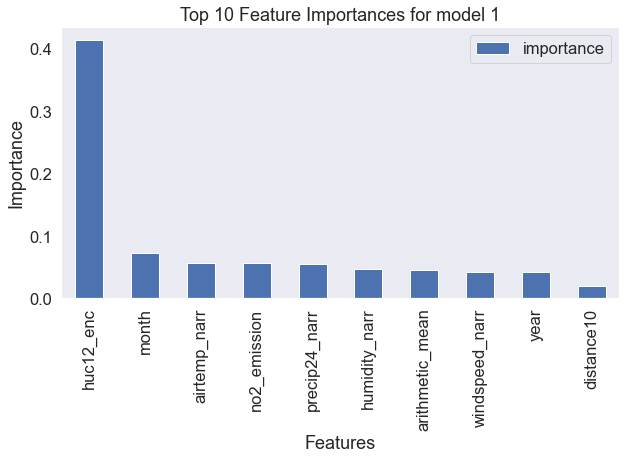

############# For model 2 ################
Evaluation Metrics
Explained Variance: 0.9029004904212133
r2: 0.9027256004979416
Mean Squared Error: 0.5445163976656447
Root Mean Square Error: 0.7379135434897809
95% Confidence Interval: [0.47391673 0.92975036] mg/L


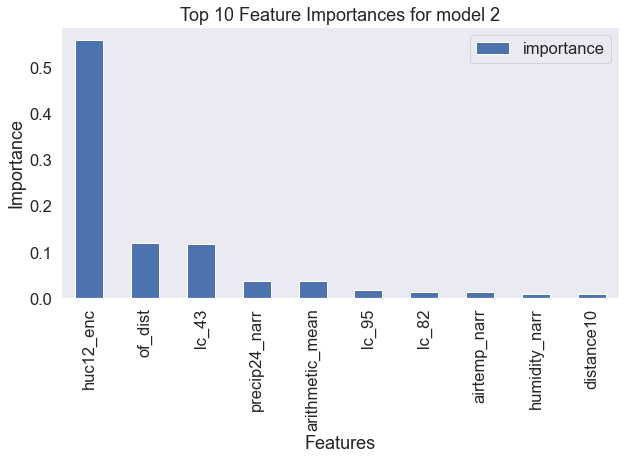

Total Metrics:
Mean Squared Error:  0.36842805159581143
RMSE :  0.6069827440675818


In [74]:
preds = model_predict()

Further segmentation or additional relevant features may help make more accurate predictions.
Whern looking at the feature importances side by side, the target mean encoding of the HUC12 feature is the most important feature for both models. This makes sense that the previous averages of TN within the HUC will help predict future TN readings, this feature helps capture the variability between HUC12 areas. 

The first group's top features asie from the mean encoding feature:
- month
- air temperature
- rainfall in the past 24 hours
- NO2 emissions from point sources
- humidity
- mean value of air NO2 and the year

The second group's top features aside form the mean encoding feature:
- lc_82(ratio of land that is 'cultivated crops')
- distance from the bay
- mean value of air NO2
- rainfall in the past 24 hours

This shows that there is a difference in the relationships of variables and TN sampled in the water. It would seem that Group 1's TN values rely upon seasonal fluctuations, weather, NO2 emissions (from correlated point sources) and air NO2 values(from point sources and nearby cities/non point sources). This could  mean that a focus on reducing TN from point sources and non-point sources would help reduce TN in the bay.

Group 2's TN values rely more upon how land cover is utilized, specifically crop land. Determining  ways to mitigate cropland run off could help reduce TN. An explanation for 'distance to the outflow of the bay' being such an important feature, is that there is less water for the pollutant to be dilluted in the further from the bay you are, making run off TN values


In [75]:
import pickle
#save the model to disk
fname = os.path.join(PROJ_ROOT, 
                         'models',
                         'ensemble_rf_model.sav')
pickle.dump(models, open(fname, 'wb'))

### Model 2 Shap Summary Plot

In [76]:
## Transform the data using the column transformer
X_train_prepared = preprocessor.fit_transform(models['X_train'][0])
y_train_values = models['y_train'][0].values

X_test_prepared = preprocessor.transform(models['X_test'][0])
X_test_prepared = X_test_prepared
y_test_values =  models['y_test'][0].values

#record accurate column names
data_names = numeric_features+['year','month']

#create the new transformed data frame
# X_test_df = pd.DataFrame(data=X_test_prepared, columns=data_names)
X_train_df = pd.DataFrame(data=X_train_prepared, columns=data_names)

In [77]:
# pass on the parameters from the best estimator frmo the GridsearchCV
rf_model = RandomForestRegressor(**models['model'][0].best_params_['clf'].get_params()).fit(X_train_prepared, y_train_values)


In [78]:
#att in the newly created model
explainer = shap.TreeExplainer(rf_model)
# pass in the transformed data
shap_values1 = explainer.shap_values(X_train_df)

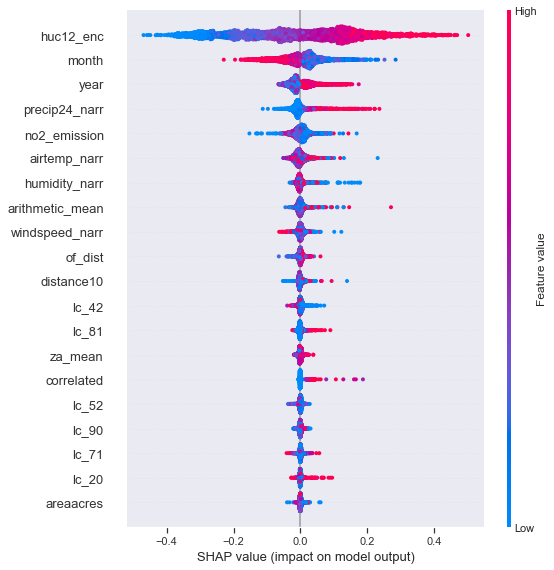

In [79]:
#display the plot
shap.summary_plot(shap_values1, X_train_df)

## Model 2 Shap Summary Plot

In [80]:
## Transform the Validation Set
X_train_prepared = preprocessor.fit_transform(models['X_train'][1])
y_train_values = models['y_train'][1].values

# ## requires dense matrix
X_test_prepared = preprocessor.transform(models['X_test'][1])
X_test_prepared = X_test_prepared
y_test_values =  models['y_test'][1].values

data_names = numeric_features+['year','month']

# X_test_df = pd.DataFrame(data=X_test_prepared, columns=data_names)
X_train_df = pd.DataFrame(data=X_train_prepared, columns=data_names)

In [81]:
rf_model = RandomForestRegressor(**models['model'][1].best_params_['clf'].get_params()).fit(X_train_prepared, y_train_values)


In [82]:
explainer = shap.TreeExplainer(rf_model)
shap_values2 = explainer.shap_values(X_train_df)

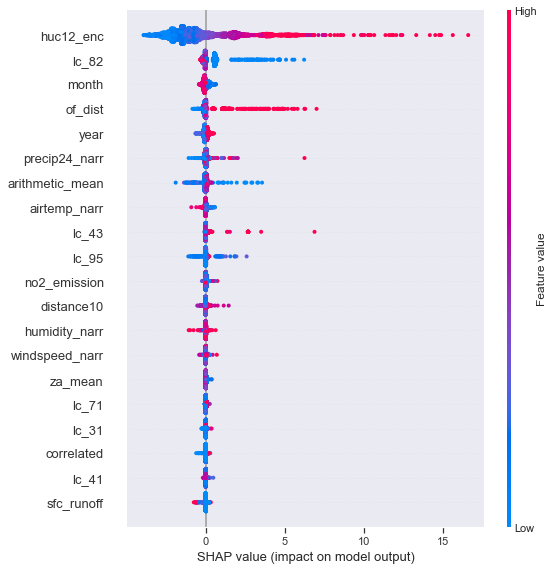

In [83]:
#display the plot
shap.summary_plot(shap_values2, X_train_df)

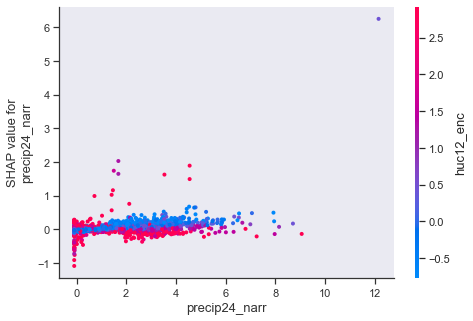

In [84]:
X_train_prepared = preprocessor.fit_transform(models['X_train'][1])
X_train_df = pd.DataFrame(data=X_train_prepared, columns=data_names)
shap.dependence_plot("precip24_narr", shap_values2, X_train_df)

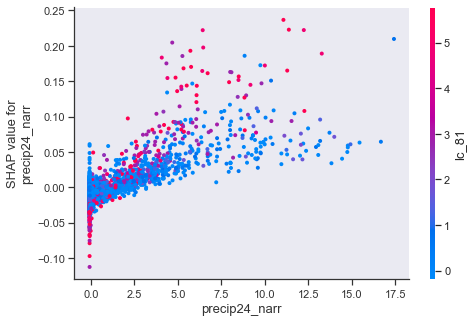

In [85]:
X_train_prepared = preprocessor.fit_transform(models['X_train'][0])
data_names = numeric_features+['year','month']
X_train_df = pd.DataFrame(data=X_train_prepared, columns=data_names)
shap.dependence_plot("precip24_narr", shap_values1, X_train_df)

In [86]:
import pickle
#save the model to disk
fname = os.path.join(PROJ_ROOT, 
                         'models',
                         'shapvals1.sav')
pickle.dump(shap_values1, open(fname, 'wb'))

import pickle
#save the model to disk
fname = os.path.join(PROJ_ROOT, 
                         'models',
                         'shapvals2.sav')
pickle.dump(shap_values2, open(fname, 'wb'))